# MyND Offline Processing
Author: Geeling Chau<br> 
Description: Process xdf files recorded from experimental sessions to determine file eligibility and data feature extraction.<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp


## Imports

In [1]:
from helperFunctions import *
from constants import *

## Main

### Get Data

In [2]:
'''
Files that work with this notebook: 
participant_P004_exp001_block_full_start.xdf # full start
participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
participant_P004_exp003_block_full_start.xdf # This should work too
participant_P004_exp001_block_full_short.xdf # Works (no instructions section tho)
participant_P004_exp001_block_full_long.xdf # Works (no instructions section tho)

'''

XDF_Data = loadxdf("../data/P004/participant_P004_exp001_block_full_short.xdf")
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
if StreamType.EYE.value in XDF_Data : 
    time_differences_eye_tracker = [XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
    mean_fs_eye_tracker = 1/np.mean(time_differences_eye_tracker)
    eye_fs = int(mean_fs_eye_tracker)
    print("eye_fs = ", eye_fs)
# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

markers = np.array(XDF_Data[MARKER_STREAM_TYPE][DATA_STREAM_TYPE][:,0])
marker_indexes = {}
for index, marker in enumerate(markers): 
    marker_indexes[marker] = index
    


eeg_fs =  250
eye_fs =  37


In [3]:
# Recording data checks (whether all markers are there etc)
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in markers: 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)


Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --LettersShown
All Markers Found? False


### Check time stamps

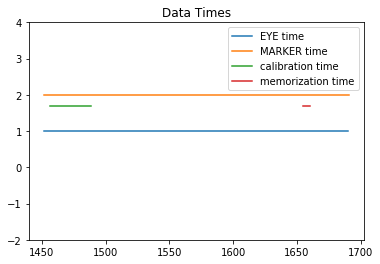

In [4]:
start_times = {}
end_times = {}
#start_times[StreamType.EEG.value] = XDF_Data[StreamType.EEG.value][StreamType.TIME.value][0]
#end_times[EEG_STREAM_TYPE] = XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][-1]

start_times[EYE_STREAM_TYPE] = XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][0]
end_times[EYE_STREAM_TYPE] = XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][-1]

start_times[MARKER_STREAM_TYPE] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][0]
end_times[MARKER_STREAM_TYPE] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][-1]

start_times["Calibration"] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][marker_indexes[PSYCHO_PY_MARKERS["calibrationStart"]]]
end_times["Calibration"] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][marker_indexes[PSYCHO_PY_MARKERS["calibrationStop"]]]

start_times["Memorization"] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][marker_indexes[PSYCHO_PY_MARKERS["memorizationStart"]]]
end_times["Memorization"] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][marker_indexes[PSYCHO_PY_MARKERS["memorizationStop"]]]

#start_times["Instruction"] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][marker_indexes[PSYCHO_PY_MARKERS["instructionStart"]]]
#end_times["Instruction"] = XDF_Data[MARKER_STREAM_TYPE][TIME_STREAM_TYPE][marker_indexes[PSYCHO_PY_MARKERS["instructionStop"]]]


#plt.plot([start_times[EEG_STREAM_TYPE], end_times[EEG_STREAM_TYPE]], [0,0], label="EEG time")
plt.plot([start_times[EYE_STREAM_TYPE], end_times[EYE_STREAM_TYPE]], [1,1], label="EYE time")
plt.plot([start_times[MARKER_STREAM_TYPE], end_times[MARKER_STREAM_TYPE]], [2,2], label="MARKER time")
plt.plot([start_times["Calibration"], end_times["Calibration"]], [1.7,1.7], label="calibration time")
plt.plot([start_times["Memorization"], end_times["Memorization"]], [1.7,1.7], label="memorization time")
# plt.plot([start_times["Instruction"], end_times["Instruction"]], [1.8,1.8], label="instruction time")



plt.ylim((-2, 4))
plt.title("Data Times")
plt.legend()
plt.show()

In [5]:
# Check we have values in the right channels
XDF_Data[EEG_STREAM_TYPE][DATA_STREAM_TYPE][0]

array([377.875  , 429.26855,   0.     ,   0.     ,   0.     ,   0.     ,
       171.35352, 476.9043 ], dtype=float32)

### Check Sampling for Eye

Max time difference of eye tracker:				 0.1354156422955839
Min time difference of eye tracker:				 0.01252793119465423
Avg time difference of eye tracker:				 0.027022108053811982
Mean eye sampling frequency (should be 30-50Hz):		 37.00673530016956
Number of eye samples (should be >7000 for a full 5 min run):	 8825


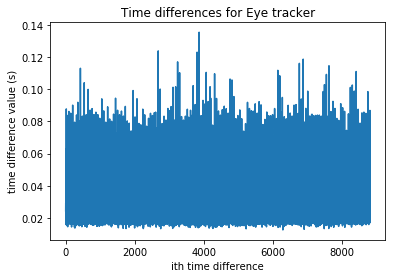

Markers around largest time difference (--PsychopyStart is reasonable): [['--Blank']
 ['--SpaceNotPressed']
 ['--CorrectResponse']
 ['3']
 ['--EndWord']
 ['--NewWord']
 ['3']
 ['these']
 ['1.2255523642179964']
 ['--NotTargetWord']
 ['--Blank']
 ['--SpaceNotPressed']
 ['--CorrectResponse']
 ['3']
 ['--EndWord']
 ['--NewWord']
 ['3']
 ['video']
 ['1.2104540298895745']
 ['--NotTargetWord']]


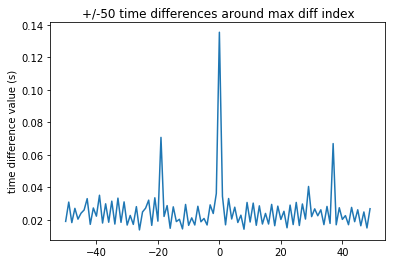

In [6]:
# Sanity Checks for Eye Sampling
time_differences_eye_tracker = [XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
mean_fs_eye_tracker = 1/np.mean(time_differences_eye_tracker)
std_fs_eye_tracker = np.std(time_differences_eye_tracker)
num_samples_eye_tracker = len(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE])

print("Max time difference of eye tracker:\t\t\t\t", max(time_differences_eye_tracker))
print("Min time difference of eye tracker:\t\t\t\t", min(time_differences_eye_tracker))
print("Avg time difference of eye tracker:\t\t\t\t", np.mean(time_differences_eye_tracker))

print("Mean eye sampling frequency (should be 30-50Hz):\t\t", mean_fs_eye_tracker)
print("Number of eye samples (should be >7000 for a full 5 min run):\t", num_samples_eye_tracker)


# Visualize EEG recording gaps
plt.plot(list(range(len(time_differences_eye_tracker))), time_differences_eye_tracker)
plt.title("Time differences for Eye tracker")
plt.xlabel("ith time difference")
plt.ylabel("time difference value (s)")
plt.show()

# Inspect largest eye data pause: 
len_range = 50
index_of_max_time_differences_eye_tracker = time_differences_eye_tracker.index(max(time_differences_eye_tracker))
# print("Time differences around Max diff:", time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+25])


new_data = epochByTime(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][index_of_max_time_differences_eye_tracker - len_range], XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][index_of_max_time_differences_eye_tracker + len_range], XDF_Data)
print("Markers around largest time difference (--PsychopyStart is reasonable):", new_data[StreamType.MARKER.value][StreamType.DATA.value])

plt.plot(np.array(list(range(len(time_differences_eye_tracker[index_of_max_time_differences_eye_tracker-len_range:index_of_max_time_differences_eye_tracker+len_range])))) - len_range, time_differences_eye_tracker[index_of_max_time_differences_eye_tracker-len_range:index_of_max_time_differences_eye_tracker+len_range])
plt.title("+/-" + str(len_range)+ " time differences around max diff index")
plt.ylabel("time difference value (s)")


plt.show()

## Check Sampling for EEG

Max time difference of eeg (0.15 - 0.5 is reasonable):	 0.047282727991159845
Min time difference of eeg (0.0001 is reasonable):	 0.00017939900749297522
Avg time difference of eeg (should be ~0.004):		 0.003991908734737467
Mean eye sampling frequency (should be 250Hz):		 250.50672909879697
Number of eeg samples (should be 75,000 for a full 5 min run):	 59741


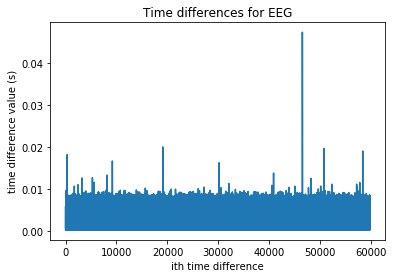

Markers around largest time difference (--PsychopyStart is reasonable): [['--SpaceNotPressed']
 ['--CorrectResponse']
 ['11']
 ['--EndWord']
 ['--NewWord']
 ['11']
 ['selection']
 ['1.287548896551863']
 ['--NotTargetWord']]


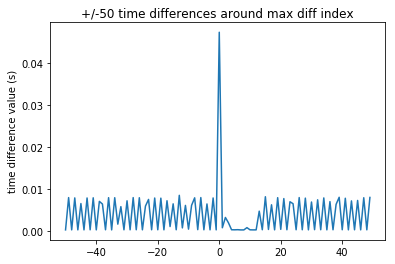

In [7]:
# Check EEG data times

time_differences_eeg = [XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
mean_fs_eeg = 1/np.mean(time_differences_eeg)
num_samples_eeg = len(XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE])


print("Max time difference of eeg (0.15 - 0.5 is reasonable):\t", max(time_differences_eeg))
print("Min time difference of eeg (0.0001 is reasonable):\t", min(time_differences_eeg))
print("Avg time difference of eeg (should be ~0.004):\t\t", np.mean(time_differences_eeg))


print("Mean eye sampling frequency (should be 250Hz):\t\t", mean_fs_eeg)
print("Number of eeg samples (should be 75,000 for a full 5 min run):\t", num_samples_eeg)

# Visualize EEG recording gaps
plt.plot(list(range(len(time_differences_eeg))), time_differences_eeg)
plt.title("Time differences for EEG")
plt.xlabel("ith time difference")
plt.ylabel("time difference value (s)")
plt.show()

# Inspect largest EEG data pause: 
len_range = 50
index_of_max_time_differences_eeg = time_differences_eeg.index(max(time_differences_eeg))
# print("Time differences around Max diff:", time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+25])


new_data = epochByTime(XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][index_of_max_time_differences_eeg - len_range], XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][index_of_max_time_differences_eeg + len_range], XDF_Data)
print("Markers around largest time difference (--PsychopyStart is reasonable):", new_data[StreamType.MARKER.value][StreamType.DATA.value])

plt.plot(np.array(list(range(len(time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+len_range])))) - len_range, time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+len_range])
plt.title("+/-" + str(len_range)+ " time differences around max diff index")
plt.ylabel("time difference value (s)")


plt.show()

### Check Data for Eye

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/checks.py:144: UserWarning: Transition bandwidth is  4.0  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an 

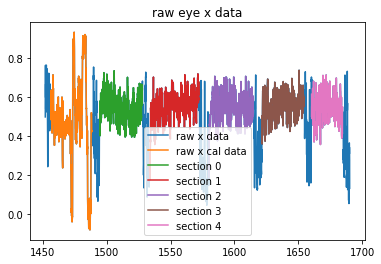

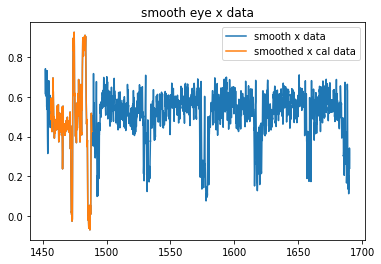

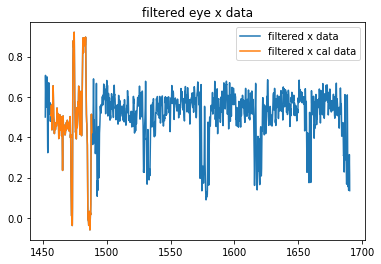

In [8]:
# Check eye data

eye_x_data=XDF_Data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data=XDF_Data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
eye_time_data=XDF_Data[StreamType.EYENORM.value][StreamType.TIME.value]

calibration_data = getSectionData("calibration", XDF_Data)

numSections = getNumSections(XDF_Data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, XDF_Data))
eye_x_data_calibration=calibration_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data_calibration=calibration_data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
eye_time_data_calibration=calibration_data[StreamType.EYENORM.value][StreamType.TIME.value]


N = 5
smoothed_eye_x_data = np.convolve(eye_x_data, np.ones((N,))/N, mode='valid')
smoothed_eye_y_data = np.convolve(eye_y_data, np.ones((N,))/N, mode='valid')
smoothed_eye_x_calibration_data = np.convolve(eye_x_data_calibration, np.ones((N,))/N, mode='valid')

f_hi = 2
filtered_eye_x_data = filterEYE(eye_x_data, fs=eye_fs, f_hi=2)
filtered_eye_y_data = filterEYE(eye_y_data, fs=eye_fs, f_hi=2)
filtered_eye_x_calibration_data = filterEYE(eye_x_data_calibration, fs=eye_fs, f_hi=2)


plt.plot(eye_time_data, eye_x_data, label="raw x data")
plt.plot(eye_time_data_calibration, eye_x_data_calibration, label="raw x cal data")
for i in range(numSections) : 
    plt.plot(article_sections[i][StreamType.EYENORM.value][StreamType.TIME.value], article_sections[i][StreamType.EYENORM.value][StreamType.DATA.value][:,0], label="section " + str(i))
    
plt.legend()
plt.title("raw eye x data")
plt.show()

plt.plot(eye_time_data[N-1:], smoothed_eye_x_data, label="smooth x data")
plt.plot(eye_time_data_calibration[N-1:], smoothed_eye_x_calibration_data, label="smoothed x cal data")
plt.title("smooth eye x data")
plt.legend()
plt.show()

plt.plot(eye_time_data, filtered_eye_x_data, label="filtered x data")
plt.plot(eye_time_data_calibration, filtered_eye_x_calibration_data, label="filtered x cal data")
plt.title("filtered eye x data")
plt.legend()
plt.show()


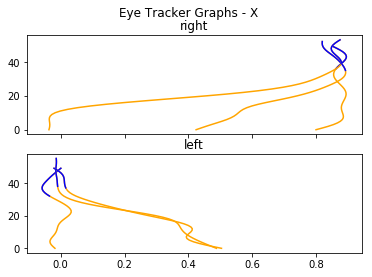

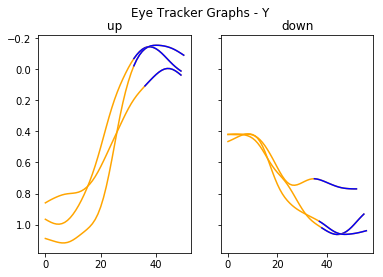

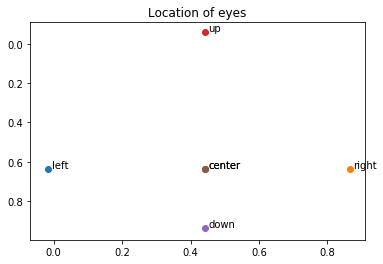

x_eye_tracker_pass: True
y_eye_tracker_pass: True


In [9]:
# Calibration processing of eye blinks and summary sanity checks
calibrated_x = {}
calibrated_y = {}

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title("right")
ax2.set_title("left")
fig.suptitle("Eye Tracker Graphs - X")

fig2, (ay1, ay2) = plt.subplots(1, 2, sharey=True)
ay1.set_title("up")
ay2.set_title("down")
ay1.invert_yaxis() 
fig2.suptitle("Eye Tracker Graphs - Y")


# Smoothing for eye data (cut off frequency)
f_hi = 2

for x_dir in PSYCHOPY_DIRECTIONS_X.keys():
    for y_dir in PSYCHOPY_DIRECTIONS_Y.keys(): 
        location = "("+str(PSYCHOPY_DIRECTIONS_X[x_dir])+", "+str(PSYCHOPY_DIRECTIONS_Y[y_dir])+")"
        new_data = epochByMarkIndex(marker_indexes[location] - 2, marker_indexes[location], XDF_Data)
        x = new_data[EYE_NORM_STREAM_TYPE]['data'][:,0]
        x = filterEYE(x, eye_fs, f_hi=f_hi)
        new_data[EYE_NORM_STREAM_TYPE]['data'][:,0] = x
        y = new_data[EYE_NORM_STREAM_TYPE]['data'][:,1]
        y = filterEYE(y, eye_fs, f_hi=f_hi)
        new_data[EYE_NORM_STREAM_TYPE]['data'][:,1] = y
        time = new_data[EYE_NORM_STREAM_TYPE]['time']
        timepoints=range(len(time))
        if(x_dir == 'right') :
            ax1.plot(x, timepoints, color="orange")
        if(x_dir == 'left') :
            ax2.plot(x, timepoints, color="orange")
        
        if(y_dir == 'up') :
            ay1.plot(timepoints, y, color="orange")
        if(y_dir == 'down') :
            ay2.plot(timepoints, y, color="orange")
        
        # Get only the last 1/3 of time data from x
        time_range = time[-1] - time[0]
        time_range = time_range*2 / 3
        start_time = time[0] + time_range
        end_time = time[-1]
        
        third_data = epochByTime(start_time, end_time, new_data)
        x = third_data[EYE_NORM_STREAM_TYPE]['data'][:,0]
        y = third_data[EYE_NORM_STREAM_TYPE]['data'][:,1]
        time_third = third_data[EYE_NORM_STREAM_TYPE]['time']
        timepoints = np.array(list(range(len(time_third)))) + len(time) - len(time_third)
        if(x_dir == 'right') :
            ax1.plot(x, timepoints, color="blue")
        if(x_dir == 'left') :
            ax2.plot(x, timepoints, color="blue")
            
        if(y_dir == 'up') :
            ay1.plot(timepoints, y, color="blue")
        if(y_dir == 'down') :
            ay2.plot(timepoints, y, color="blue")
        
        
        # Append new average to calibration matricies
        avg_x = np.mean(x)
        avg_y = np.mean(y)
        
        if x_dir not in calibrated_x: 
            calibrated_x[x_dir] = list()
        if y_dir not in calibrated_y: 
            calibrated_y[y_dir] = list()
        calibrated_x[x_dir].append(avg_x)
        calibrated_y[y_dir].append(avg_y)
    
plt.show()

# Average the eye locations
avg_calibrated_x = {}
avg_calibrated_y = {}
for x_dir in calibrated_x: 
    avg_calibrated_x[x_dir] = np.mean(calibrated_x[x_dir])
for y_dir in calibrated_y:
    avg_calibrated_y[y_dir] = np.mean(calibrated_y[y_dir])
    
# Plot the eye averages
for x_dir in avg_calibrated_x: 
    x = avg_calibrated_x[x_dir]
    y = avg_calibrated_y['center']
    plt.scatter([x], [y], label=x_dir)
    plt.annotate(
        x_dir,
        xy=(x+0.01, y-0.005))
for y_dir in avg_calibrated_y:
    x = avg_calibrated_x['center']
    y = avg_calibrated_y[y_dir]
    plt.scatter([x], [y], label=y_dir)
    plt.annotate(
        y_dir,
        xy=(x+0.01, y-0.005))
plt.gca().invert_yaxis()
plt.title("Location of eyes");
plt.show()

# Summary 
x_eye_tracker_pass = False
y_eye_tracker_pass = False
if (avg_calibrated_x['center'] - avg_calibrated_x['left'] > 0) and (avg_calibrated_x['right'] - avg_calibrated_x['center'] > 0):
    x_eye_tracker_pass = True

if (avg_calibrated_y['center'] - avg_calibrated_y['up'] > 0) and (avg_calibrated_y['down'] - avg_calibrated_y['center'] > 0):
    y_eye_tracker_pass = True
    
print("x_eye_tracker_pass:", x_eye_tracker_pass)
print("y_eye_tracker_pass:", y_eye_tracker_pass)

## Meme showing eye movements vs Points. 
Looking Right should predict when they look at the meme

In [10]:
meme_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", XDF_Data, go_backward=False)

In [11]:
meme_shown_data, a, b = getTimeBoundSingleLabelData("newMeme", XDF_Data, time_before=1, time_after=3)

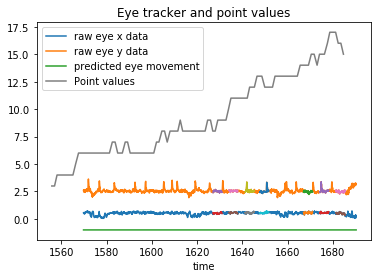

In [12]:
eye_x_data=XDF_Data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data=XDF_Data[StreamType.EYENORM.value][StreamType.DATA.value][:,1] + 2
eye_time_data=XDF_Data[StreamType.EYENORM.value][StreamType.TIME.value]

plt.plot(eye_time_data[len(eye_time_data)//2:], eye_x_data[len(eye_time_data)//2:], label="raw eye x data")
plt.plot(eye_time_data[len(eye_time_data)//2:], eye_y_data[len(eye_time_data)//2:], label="raw eye y data")


x_threshold_center_right = avg_calibrated_x['right']
N=1
smoothed_eye_x_data = np.convolve(eye_x_data, np.ones((N,))/N, mode='valid')
looking_right = [-0 if val > x_threshold_center_right else -1 for i, val in enumerate(smoothed_eye_x_data)]
plt.plot(eye_time_data[len(eye_time_data)//2+N-1:], looking_right[len(eye_time_data)//2:], label="predicted eye movement")


for i in range(len(meme_shown_data)): 
    eye_x_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.DATA.value][:,0]
    eye_y_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.DATA.value][:,1] + 2
    eye_time_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.TIME.value]

    plt.plot(eye_time_data, eye_x_data)
    plt.plot(eye_time_data, eye_y_data)


data, time = getPointsAfterEachWord(XDF_Data)
plt.plot(time[len(time)//3:], data[len(time)//3:], label="Point values")
plt.title("Eye tracker and point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Visualize Blink-related Data


In [13]:
# Get data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=XDF_Data)
blink_data=new_data[0]

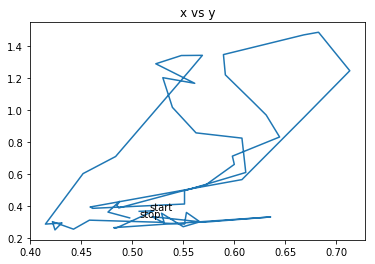

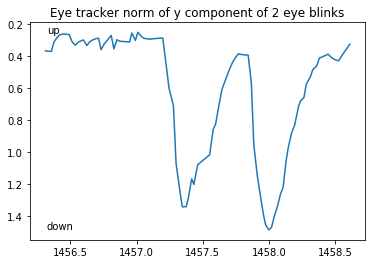

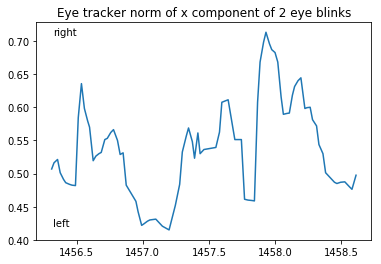

In [14]:
# Check eye tracker
eye_norm_data_x = blink_data[EYE_NORM_STREAM_TYPE]['data'][:,0]
eye_norm_data_y = blink_data[EYE_NORM_STREAM_TYPE]['data'][:,1]
eye_norm_data_time = blink_data[EYE_NORM_STREAM_TYPE]['time']

plt.annotate(
    "start",
    xy=(eye_norm_data_x[0]+0.01, eye_norm_data_y[0] + 0.005))
plt.annotate(
    "stop",
    xy=(eye_norm_data_x[-1]+0.01, eye_norm_data_y[-1] + 0.005))
plt.plot(eye_norm_data_x, eye_norm_data_y)
plt.title("x vs y")
plt.show()

plt.annotate(
    "down",
    xy=(eye_norm_data_time[0]+0.01, max(eye_norm_data_y)-0.005))
plt.annotate(
    "up",
    xy=(eye_norm_data_time[0]+0.01, min(eye_norm_data_y)+0.005))

plt.plot(eye_norm_data_time, eye_norm_data_y)
plt.title("Eye tracker norm of y component of 2 eye blinks")
plt.gca().invert_yaxis()
plt.show()

plt.annotate(
    "right",
    xy=(eye_norm_data_time[0]+0.01, max(eye_norm_data_x)-0.005))
plt.annotate(
    "left",
    xy=(eye_norm_data_time[0]+0.01, min(eye_norm_data_x)+0.005))


plt.plot(eye_norm_data_time, eye_norm_data_x)
plt.title("Eye tracker norm of x component of 2 eye blinks")
plt.show()

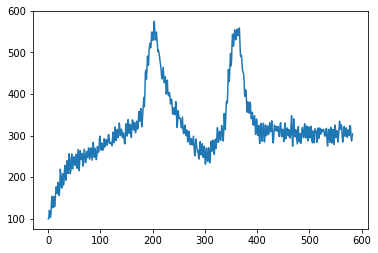

In [15]:
veog_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['VEOG']]
plt.plot(veog_eeg)

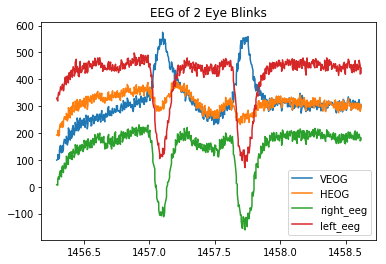

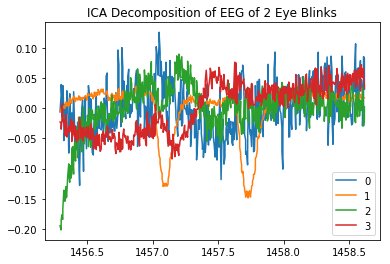

In [16]:
# Check EEG
veog_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['VEOG']]
heog_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['HEOG']]
left_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['left_eeg']]
right_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['right_eeg']]
active_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,list(channels.values())]
eeg_time = blink_data[EEG_STREAM_TYPE]['time']


# EEG eye blink data
line_objects = plt.plot(eeg_time, active_eeg)
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("EEG of 2 Eye Blinks")
plt.show()

ica = FastICA(n_components=4)
standardized=active_eeg
standardized /= active_eeg.std(axis=0)
S = ica.fit_transform(active_eeg)  # Reconstruct signals
A = ica.mixing_
line_objects = plt.plot(eeg_time, S)
plt.legend(iter(line_objects), list(range(len(line_objects))))
plt.title("ICA Decomposition of EEG of 2 Eye Blinks")
plt.show()

In [17]:
remove_indices = [2]  # pretend the user selected components 0, 1, and 3

# "remove" unwanted components by setting them to 0 - simplistic but gets the job done
S[:, remove_indices] = 0

#reconstruct signal
X_restored = ica.inverse_transform(S)

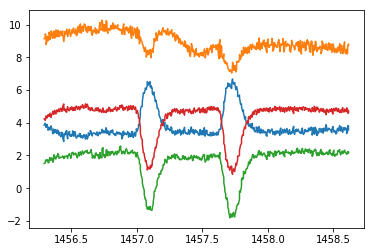

In [18]:
plt.plot(eeg_time, X_restored)

### EEG Filtering and Frequency Check

In [19]:
# Check All Data
channel = channels['right_eeg']
eeg_data=XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channel]
sig_filt = filterEEG(eeg_data, eeg_fs)

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/checks.py:144: UserWarning: Transition bandwidth is  42.8  Hz. This is greater than the desiredpass/stop bandwidth of  39.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: F

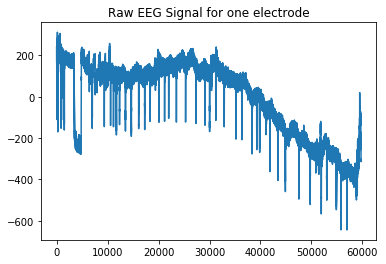

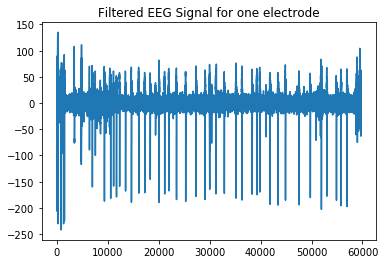

In [20]:
plt.plot(eeg_data)
plt.title("Raw EEG Signal for one electrode")
plt.show()

plt.plot(sig_filt)
plt.title("Filtered EEG Signal for one electrode")
plt.show()

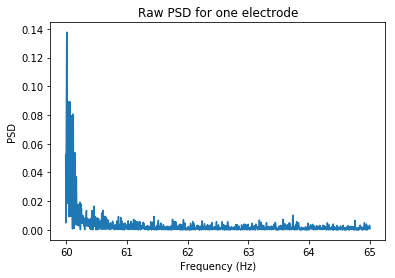

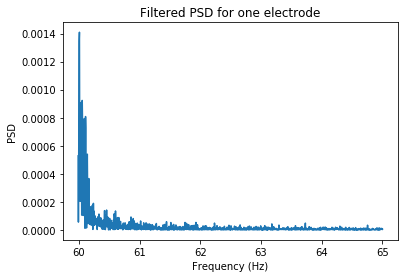

In [21]:
# See the 60Hz data
margin =  600 #len(freq) // 2 means all. 600 to see 60Hz

freq, psd = signal.periodogram(eeg_data, fs=int(eeg_fs), scaling='spectrum')
psd_mean = np.average(psd, axis = 0)
#print(psd_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD') # not sure what the unit is...
plt.title('Raw PSD for one electrode')
plt.plot(freq[len(freq) // 2 - margin : len(freq) // 2 + margin], psd[len(freq) // 2 - margin : len(freq) // 2 + margin])
plt.show()

freq, psd = signal.periodogram(sig_filt, fs=int(eeg_fs), scaling='spectrum')
psd_mean = np.average(psd, axis = 0)
#print(psd_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD') # not sure what the unit is...
plt.title('Filtered PSD for one electrode')
plt.plot(freq[len(freq) // 2 - margin : len(freq) // 2 + margin], psd[len(freq) // 2 - margin : len(freq) // 2 + margin])
plt.show()


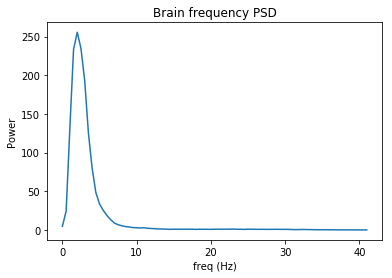

In [22]:
# See the 1-40hz data
freq_mean, psd_mean = spectral.compute_spectrum(sig_filt, eeg_fs, method='welch', avg_type='mean', nperseg=eeg_fs*2)
plt.title("Brain frequency PSD")
plt.xlabel("freq (Hz)")
plt.ylabel("Power")
plt.plot(freq_mean[:len(freq_mean)//3], psd_mean[:len(freq_mean)//3])
plt.show()

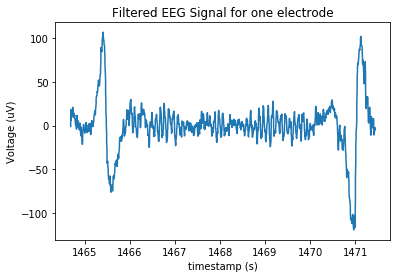

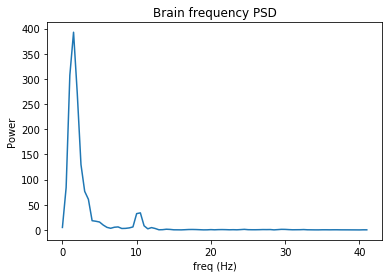

In [23]:
# Check Eye Close Data
new_data, a, b = getMarkerBoundSingleMarkerData(closeEyeText, "--SpacePressed", original_data=XDF_Data)
close_eye_data = new_data[0]
eeg_data=close_eye_data[StreamType.EEG.value][StreamType.DATA.value][:,channel]
time_data=close_eye_data[StreamType.EEG.value][StreamType.TIME.value][:]


sig_filt = filterEEG(eeg_data, eeg_fs)

plt.plot(time_data, sig_filt)
plt.title("Filtered EEG Signal for one electrode")
plt.xlabel("timestamp (s)")
plt.ylabel("Voltage (uV)")
plt.show()


# alpha_range=(9, 11)
# # Compute instaneous amplitude from a signal
# amp = amp_by_time(sig_filt, eeg_fs, alpha_range)
# plt.plot(time_data, amp)
# plt.title("Alpha amp by time")
# plt.xlabel("timestamp (s)")
# plt.ylabel("amp")
# plt.show()


freq_mean, psd_mean = spectral.compute_spectrum(sig_filt, eeg_fs, method='welch', avg_type='mean', nperseg=eeg_fs*2)
plt.title("Brain frequency PSD")
plt.xlabel("freq (Hz)")
plt.ylabel("Power")
plt.plot(freq_mean[:len(freq_mean)//3], psd_mean[:len(freq_mean)//3])

plt.show()


In [25]:
# Check Instructions Reading Data (only works with START)
instruction_data = getSectionData("instruction", XDF_Data)
eeg_data=instruction_data[StreamType.EEG.value][StreamType.DATA.value][:,channel]
sig_filt = filterEEG(eeg_data, eeg_fs)

plt.plot(sig_filt)
plt.title("Filtered EEG Signal for one electrode")
plt.show()


freq_mean, psd_mean = spectral.compute_spectrum(sig_filt, eeg_fs, method='welch', avg_type='mean', nperseg=eeg_fs*2)
plt.title("Brain frequency PSD")
plt.xlabel("freq (Hz)")
plt.ylabel("Power")
plt.plot(freq_mean[:len(freq_mean)//3], psd_mean[:len(freq_mean)//3])

plt.show()

ValueError: The length of the input vector x must be at least padlen, which is 15.